## The Problem and the Approach

I've been using the [FitNotes](http://www.fitnotesapp.com/) app to track my workouts since 2018. Among other things, I've been doing the bar bell classics: bench press, squat, deadlift, and overhead press. Once I got the hang of the exercises, I started doing a few warm-up sets with lower weights followed by the regular sets. The problem is that I eventually decided to track the warm-up sets separately, but didn't do so in the beginning. The resulting inconsistency of my work-out log has been bothering me ever since.

More precisely, in the beginning all deadlift sets were tracked under the exercise label "Deadlift". After a while I introduced another label "Deadlift (Warm Up)" and the same goes for the other three exercises. Altogether, I have about 5000 tracked sets for the four exercises of which roughly 1000 predate the introduction of the "... (Warm Up)" labels - the precise numbers will be determined later.

Luckily, FitNotes provides a convenient backup and restore feature. A full backup comes in the form of an [SQLite3](https://en.wikipedia.org/wiki/SQLite) file, which is reasonably easy to work with. 
The task is to find the database entries representing the falsely labeled warm-up sets, and to assign the correct labels. 

While the large number of potentially falsely categorized sets essentially rules out a manual approach, the even larger number of properly categorized sets suggests a machine learning approach: train a suitable classifier model on the good data and use it to identify the bad data. 

A preview of the main function should give a good idea of the things to come:

```python
def fix_db_file(db_file):
    # get the data from the database file
    data = load_data(db_file)
    # prepare the data
    prepared_data = prepare_data(data)
    # make prediction which early sets are warm-ups
    predicted_data = predict_warm_ups(prepared_data)
    # determine the "bad" set IDs
    bad_set_ids = get_bad_ids(predicted_data)
    # update database file
    update_db_file(db_file, bad_set_ids)
```

The following packages will be used in the implementation:

In [82]:
# database and data handling
import sqlite3
import pandas as pd
import numpy as np
# classical machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
# visualization
import matplotlib.pyplot as plt
# file operations
from datetime import datetime
import shutil

## Step 1: Loading the Data

The FitNotes backups come in the form of files named like `FitNotes_Backup_2025_08_19_11_53_20.fitnotes`, for example. 
As mentioned, these are just SQLite3 files which are reasonably easy to work with (arguably as easy as it gets with SQL databases). 
To get started, I opened the file in [DB Browser for SQLite](https://sqlitebrowser.org/) which is great for exploring SQLite databases and drafting queries. In this case, I found that there are 24 tables, but only two of them are relevant:

* `exercise`: contains the information about the different exercises. The relevant columns are
    * `_id`: a numerical primary key
    * `name`: the exercise names 
* `training_log`: This contains the training logs with one row for each recorded set. The relevant columns are:
    * `_id`: again, a numerical primary key
    * `date`: the date in the format YYYY-MM-DD
    * `metric_weight`: the weight for the set in kilograms (kg)
    * `reps`: the number of repitions in the set
    * `exercise_id`: a foreign key referencing the exercise with the corresponding `_id` in the `exercise` table

With this understood, it's time to run some queries. I'm opting for a combination of `sqlite3` and `pandas` to have the query results available as dataframes and ready for further processing.

In [83]:
# Specify path of the FitNotes backup file
FITNOTES_BACKUP = "FitNotes_Backup_2025_08_19_11_53_20.fitnotes"

# Use the following function to run queries
def run_query(query, db=FITNOTES_BACKUP):
    """Run SQL query and return results as dataframe."""
    with sqlite3.connect(db) as conn:
        results = pd.read_sql(sql=query, con=conn)
    return results

Loading the relevant data from the database file involves a combination of joins and subqueries. 
First, I have to find the exercise IDs corresponding to the exercises which have a "... (Warm Up)" version, and then I can retrieve the relevant entries from the `training_log` table. 
This gives the desired `load_data()` function. 

In [84]:

exercise_ids_subquery="""
SELECT _id
FROM exercise
WHERE name LIKE '% (Warm Up)'
   OR name || ' (Warm Up)' IN (SELECT name FROM exercise)
"""

all_sets_query = f"""
SELECT
	T._id as "set_id",
	T.date as "date",
    E._id as "exc_id",
	E.name as "label",
	T.metric_weight as "weight",
	T.reps as "reps"
FROM
	training_log T,
	exercise E
WHERE
	T.exercise_id = E._id AND
	T.exercise_id IN ({exercise_ids_subquery}) AND
    E.name NOT LIKE 'Fake%'
"""

def load_data(fitnotes_backup=FITNOTES_BACKUP):
	all_sets = run_query(all_sets_query, db=fitnotes_backup)
	return all_sets


Before I take a look at the data, I want to determine the date that I started introducing the warm-up categories. This involves another simple join query.

In [85]:
def get_split_date(db_file):
    first_warm_up_query = """
    SELECT
        min(T.date) as "date"
    FROM 
        training_log T, exercise E
    WHERE
        T.exercise_id = E._id AND E.name LIKE "% (Warm Up)"
    """
    result = run_query(first_warm_up_query, db_file)
    return result['date'][0]

print("First appearance of warm-up label:", get_split_date(FITNOTES_BACKUP))

First appearance of warm-up label: 2020-02-07


I will use this date to split the data in two parts: the properly labeled "good data", and the partially incorrectly labeled "problem data". 

In [86]:
SPLIT_DATE = get_split_date(FITNOTES_BACKUP)

def good_problem_split(data):
    # extract good data
    good_mask = data['date'] >= SPLIT_DATE
    good_data = data[good_mask]
    # extract problematic data
    problem_mask = data['date'] < SPLIT_DATE
    problem_data = data[problem_mask]
    return good_data, problem_data


## Step 2: Exploring and Preparing the Data

First, it's good to know how much data there is and how much of it is properly labeled.

In [87]:
# load and split the data
raw_data = load_data()
good_sets, problem_sets = good_problem_split(raw_data)
# print the counts of elements
print("Numbers of tracked sets:")
print("----------------------------")
print(f"{'Total sets:':17}{len(raw_data):4d}")
print(f"{'Good sets:':17}{len(good_sets):4d} ({100 * len(good_sets) / len(raw_data):0.0f} %)")
print(f"{'Problem sets:':17}{len(problem_sets):4d} ({100 * len(problem_sets) / len(raw_data):0.0f} %)")


Numbers of tracked sets:
----------------------------
Total sets:      5091
Good sets:       4057 (80 %)
Problem sets:    1034 (20 %)


Next up is a look at the good sets, if only to make sure that the split was done correctly. This is indeed so, since all exercises conistently start appearing with separate warm-up categories from `SPLIT_DATE` onnward:

In [88]:
good_sets.head(15)

,set_id,date,exc_id,label,weight,reps
1034,6832,2020-02-07,112,Flat Barbell Bench Press (Warm Up),20.0,6
1035,6836,2020-02-07,37,Flat Barbell Bench Press,50.0,5
1036,6837,2020-02-07,37,Flat Barbell Bench Press,50.0,5
1037,6838,2020-02-07,37,Flat Barbell Bench Press,50.0,5
1038,6839,2020-02-07,37,Flat Barbell Bench Press,42.0,9
1039,6841,2020-02-07,113,Deadlift (Warm Up),60.0,5
1040,6846,2020-02-07,48,Deadlift,106.0,4
1041,6847,2020-02-07,48,Deadlift,106.0,4
1042,6848,2020-02-07,48,Deadlift,104.0,5
1043,6849,2020-02-07,48,Deadlift,90.0,6


Ultimately, I'm interested in the information whether a given record represents a warm-up or a regular set. Whenever this information is known (i.e. for the good data), it is contained in the `'label'` column (and implicitly in `'exc_id'`), which also contains the information about the type of exercise (i.e. bench press, deadlift, overhead press, or squat). As is, the information is not presented in the most useful way. The same can be said about the columns `'set_id'` and `'date'`. In fact, the concrete values in these columns do not seem particularly relevant, but they do contain more obviously relevant information: the sets can be grouped by `'date'` and the exercise type as extracted from `'label'` and then counted in order of increasing `'set_id'`. I will thus introduce the following extra columns to represent the relevant information more directly:

* `'type'`: The **exercise type** (i.e. bench press, deadlift, overhead press, or squat)
* `'BP'`, `'DL'`, `'OP'`, `'SQ'`: Binary dummy labels for the categorical values in `'type'`
* `'warm_up'`: The **exercise category** (1: warm-up, 0: regular, `<NA>`: unknown)
* `'grp'`: A count of **groups** of sets grouped by workout date and exercise type.
* `'set_count'`: The **set number** of each set within its group. 


In [89]:
def process_labels_etc(data_in):
    # copy data
    data_out = data_in.copy()
    # add column for exercise type
    EXC_TYPES = {"F":"Bench Press", "D":"Deadlift", "O":"Overhead Press", "L":"Squat"}
    data_out['type'] = data_out['label'].str[0].map(EXC_TYPES)
    # add dummy columns for exercise types
    data_out['BP'] = data_out['label'].str.contains('Bench').astype('Int8')
    data_out['DL'] = data_out['label'].str.contains('Deadlift').astype('Int8')
    data_out['OP'] = data_out['label'].str.contains('Overhead').astype('Int8')
    data_out['SQ'] = data_out['label'].str.contains('Squat').astype('Int8')
    # add dummy column for warm-up sets (1: warm-up, 0: regular, <NA>: unknown)
    split_mask = data_out['date'] >= SPLIT_DATE
    warm_up_labels = data_out.loc[split_mask, 'label'].str.contains('Warm Up')
    data_out.loc[split_mask, 'warm_up'] = warm_up_labels
    data_out['warm_up'] = data_out['warm_up'].astype('Int8')
    # group the sets by date and exercise type and count the gorups
    data_out['grp'] = data_out.groupby(['date', 'type']).ngroup() + 1
    # also count within each group
    data_out['set_count'] = data_out.groupby(['date', 'type']).cumcount() + 1
    return data_out

The main task is then to infer the values in `warm_up` from the other columns, excluding `exc_id` and `label`, because the latter are not reliable for the `problem sets`. In fact, the equivalent information in `label` and `exc_id` literally *is* the problem for the problem sets. 

Speaking of problems, the numerical column `'weight'` is also a little flawed, since the values for different exercise types lie in rather different ranges:

In [90]:
raw_data = load_data()
prepared_data = process_labels_etc(raw_data)

print("Average weight by exercise type:")
print(prepared_data.groupby('type')['weight'].mean())

Average weight by exercise type:
type
Bench Press       45.126016
Deadlift          90.507648
Overhead Press    32.532346
Squat             59.207232
Name: weight, dtype: float64


This can be remedied by suitably normalizing the weight. I find it most reasonable to normalize the weight on a per-group basis and I will do the same for the `'reps'` column to put the parameter on a comparable scale. While doing so, I will also compute the **set volume** (i.e. weight times reps) and a per-group normalized version thereof.

In [91]:
def add_normalized_features(data_in):
    # copy original dataframe to avoid unwanted changes
    data_out = data_in.copy()
    # add the set volume (weight * reps) as a column
    data_out['set_vol'] = data_out['weight'] * data_out['reps']
    # add per-group normalized weight, reps, and set volume columns
    max_weight = data_out.groupby('grp')['weight'].transform('max')
    max_reps = data_out.groupby('grp')['reps'].transform('max')
    max_set_vol = data_out.groupby('grp')['set_vol'].transform('max')
    data_out['norm_weight'] = data_out['weight'] / max_weight
    data_out['norm_reps'] = data_out['reps'] / max_reps
    data_out['norm_set_vol'] = data_out['set_vol'] / max_set_vol
    return data_out

Together, the functions `process_labels_etc` and `add_normalized_features` make up the `prepare_data` function mentioned in the introduction.

In [92]:
def prepare_data(data_in):
    data_out = process_labels_etc(data_in)
    data_out = add_normalized_features(data_out)
    return data_out

The following plots show the weight (blue) and reps (orange) for randomly chosen examples of set groups, both normalized on a per-group level. The main observation is that, while the per-exercise-routine within the problem data is not as consistent as within the good data, the differences are not too alarming. Chances are that a properly trained prediction model trained on the good data will also perform reasonably well on the problem data.

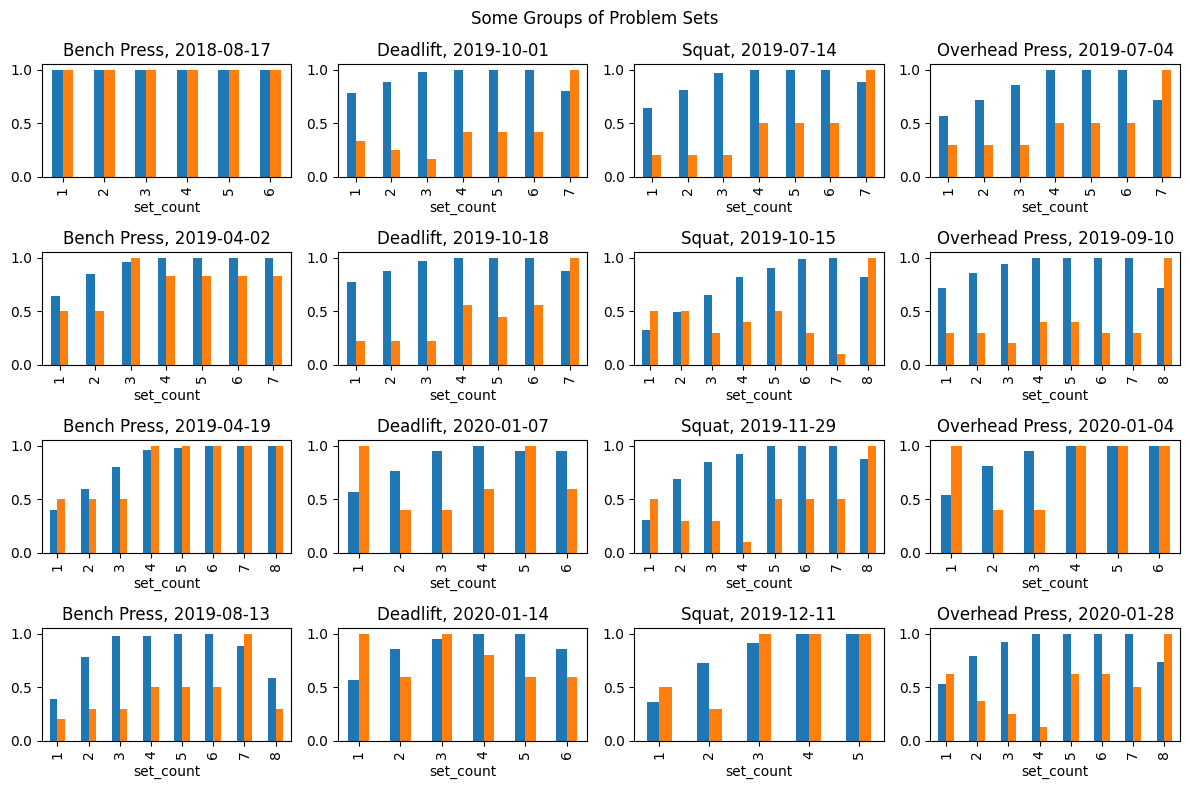

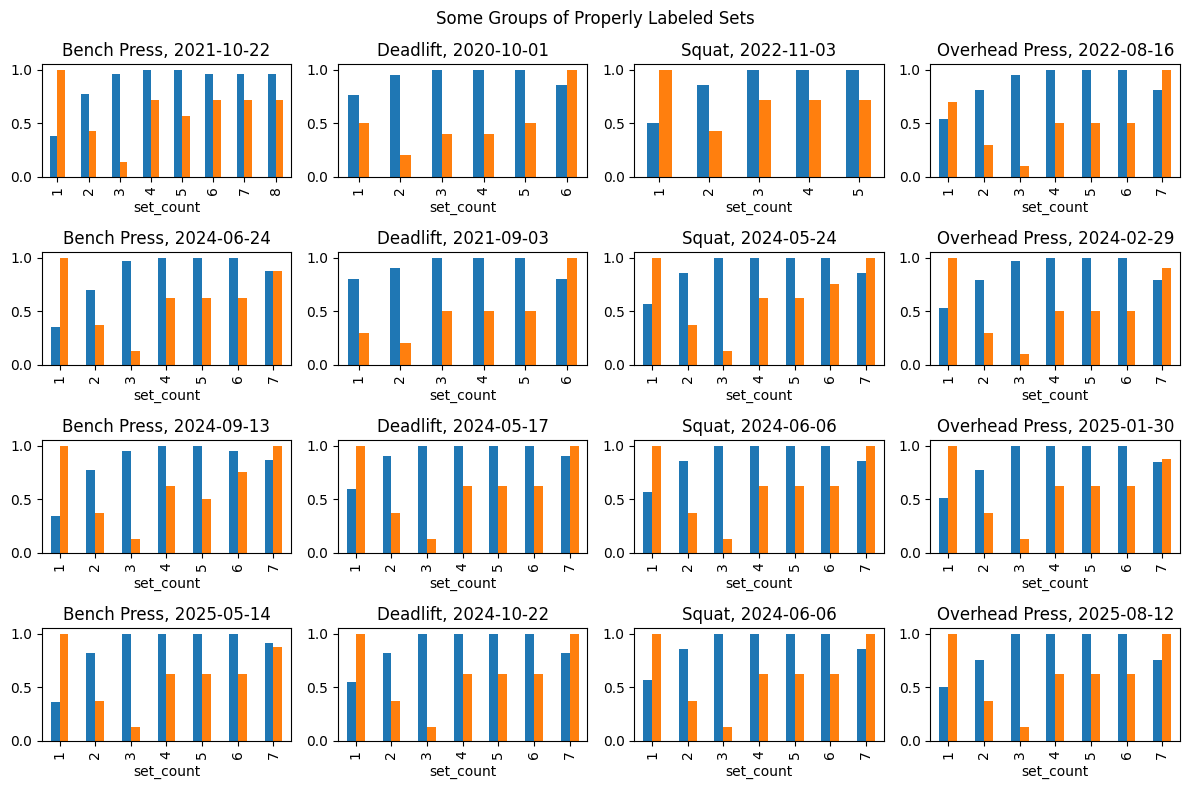

In [93]:
import random

# load, prepare, and split all sets
raw_data = load_data()
prepared_data = prepare_data(raw_data)
good_data, problems = good_problem_split(prepared_data)
split_data = {
    "Problem Sets": problems,
    "Properly Labeled Sets": good_data
}

# get samples
EXC_TYPES = prepared_data['type'].unique()
M = len(EXC_TYPES)
N = 4
group_samples = {}
for category in split_data:
    data = split_data[category]
    data_samples = []
    for exc_type in EXC_TYPES:
        exc_type_samples = []
        df = data[data['type'] == exc_type]
        sample_groups = df['grp'].sample(n=N, random_state=42)
        sample_groups.sort_values(inplace=True)
        for grp in sample_groups:
            grp_df = df[df['grp']==grp]
            exc_type_samples.append(grp_df)
        data_samples.append(exc_type_samples)
    group_samples[category] = data_samples
# plot weight and reps for the samples
W, H = 3, 2
for category in group_samples:
    fig, axes = plt.subplots(N, M, figsize=(M*W, N*H))
    fig.suptitle(f"Some Groups of {category}")
    for m in range(M):
        for n in range(N):
            df = group_samples[category][m][n].copy()
            df.set_index('set_count', inplace=True)
            date = df['date'].iloc[0]
            exc_type = df['type'].iloc[0]
            df = df[['norm_weight', 'norm_reps']]
            axes[n, m] = df.plot.bar(
                title=f"{exc_type}, {date}",
                ax=axes[n, m],  
                legend=False
            )
    plt.tight_layout()
    plt.show()



Lastly, here are the correlations of the numerical feature columns with the `'warm_up'`:

In [94]:
# reload, prepare, and split the data
raw_data = load_data()
prepared_data = prepare_data(raw_data)
good_data, problems = good_problem_split(prepared_data)

# extract the numerical column
numerical_data = good_data.select_dtypes(include=['number'])

# Compute absolute corellations
corellations = numerical_data.corr().abs()
# Restrict to `is_warm_up` colum and sort by descreasing corellation
corellations = corellations['warm_up'].sort_values(ascending=False)

# Print the results
print("Correllation of numerical columns with 'warm_up':")
print(corellations)

Correllation of numerical columns with 'warm_up':
warm_up         1.000000
set_count       0.782057
exc_id          0.736627
norm_set_vol    0.722205
norm_weight     0.610597
set_vol         0.535162
norm_reps       0.339426
reps            0.335302
weight          0.281679
grp             0.022953
BP              0.021510
set_id          0.020281
SQ              0.013093
OP              0.008936
DL              0.000292
Name: warm_up, dtype: float64


Among other things, this shows that the original columns are not very strongly correlated to `warm_up`. Some of the new columns, especially `'set_count'` and `'norm_set_vol'` look much more promising. 

It remains to explain what the new column are:

* `'set_vol'`: The **set volume**, that is, the set weight times the number of repetitions.
* `'norm_weight'`: The **normalized weight** computed per group.
* `'norm_vol'`: The **normalized set volume** computed per group.

The high correlation of the set number is not surprising, because the warm-up sets should appear in the beginning of the respective groups - at least if the sets were tracked in order (which is mostly true, but not always). The higher correlation of the set volume then its factors weight and reps also makes sense, given the knowledge how I've mostly structured my workouts. The better performance of the normalized columns can be explained by the different weight ranges mentioned above.

## Step 3: Model Training and Evaluation

With slightly over 5000 samples, the dataset is small enough to test a variety of models. To reiterate, the task is to predict the correct value of `'warm_up'` from a suitable selection of other columns. This is set up as a binary classification problem, giving a variety of models to choose from. 

I will first try a few of the classics: 
    logistic regression,
    decision tree,
    random forest,
    k-nearest neighbor, and
    linear SVM.
Each of these classifiers will be trained using the same cross validation scheme and evaluated using same metrics. 

Mostly out of curiosity, I will also train a simple neural network to see how it performs. However, since the simple models already perform extremely well, the deep learning approach will eventually be discarded.

To begin with, I'll get the data ready. I'll do a split into training, test, and validation data.

In [95]:
# load and prepare data, split off good data
raw_data = load_data()
prepared_data = prepare_data(raw_data)
good_data, _ = good_problem_split(prepared_data)

# select features for treaining
IGNORE_COLS = ['date', 'label', 'type', 'exc_id', 'set_id', 'grp', 'warm_up']
X_good = good_data.drop(IGNORE_COLS, axis=1)
y_good = good_data['warm_up']

# split into train/test/validation sets
X_train_test, X_val, y_train_test, y_val = \
    train_test_split(X_good, y_good, test_size=0.1, stratify=y_good, random_state=42)
X_train, X_test, y_train, y_test = \
    train_test_split(X_train_test, y_train_test, test_size=0.2, stratify=y_train_test, random_state=42)


### Classical Binary Classifiers

As mentioned, I want to try out and compare several classical models. For that purpose, I will load them into a dictionary.

In [96]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (Linear)": LinearSVC(max_iter=5000, dual=False),
    "Naive Bayes": GaussianNB(),
}

For model selection I will first use a 5-fold cross-validation strategy on the training data.

In [97]:
def evaluate_with_cv(models:dict)->None:
    # Cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Evaluate all models
    results = {}
    print("Cross-validation results:".upper())
    for name, model in models.items():
        scores = cross_val_score(model, X_train_test, y_train_test, cv=cv, scoring="accuracy")
        results[name] = (np.mean(scores), np.std(scores))
        print(f"{name:20s} | Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

evaluate_with_cv(models)

CROSS-VALIDATION RESULTS:
Logistic Regression  | Accuracy: 0.987 ± 0.004
Decision Tree        | Accuracy: 0.985 ± 0.004
Random Forest        | Accuracy: 0.992 ± 0.005
KNN                  | Accuracy: 0.972 ± 0.003
SVM (Linear)         | Accuracy: 0.988 ± 0.006
Naive Bayes          | Accuracy: 0.980 ± 0.004


All models perform rather well, with the random forest classifier in the lead. 

Next I will check the performance on the test data and plot the confusion matrix in each case.

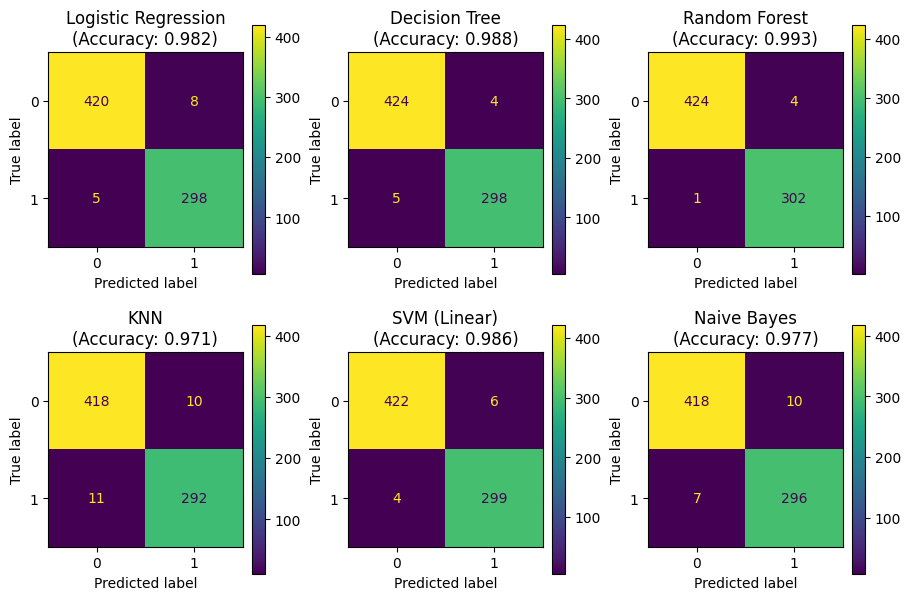

In [98]:
def plot_confusion(models):
    # create a 2-by-3 grid for the six models
    fig, axes = plt.subplots(2,3,figsize=(9,6), constrained_layout=True)
    axes = axes.flatten()
    # pupolate the axes
    ax_idx=0
    for name, model in models.items():
        # train the model on full training set
        model.fit(X_train, y_train)
        # evaluate on test set
        y_pred = model.predict(X_test)
        # compute accuracy score and confusion matrix
        accuracy = model.score(X_test, y_test)
        conf_mat = confusion_matrix(y_test, y_pred)
        conf_mat_disp = ConfusionMatrixDisplay(conf_mat)
        # add the results to current subplot
        axes[ax_idx].set_title(f"{name}\n(Accuracy: {accuracy:.3f})")
        conf_mat_disp.plot(ax=axes[ax_idx])
        ax_idx += 1
    plt.show()

plot_confusion(models)

Again, the random forest model performs best with an exceptionally low number of false negatives. 

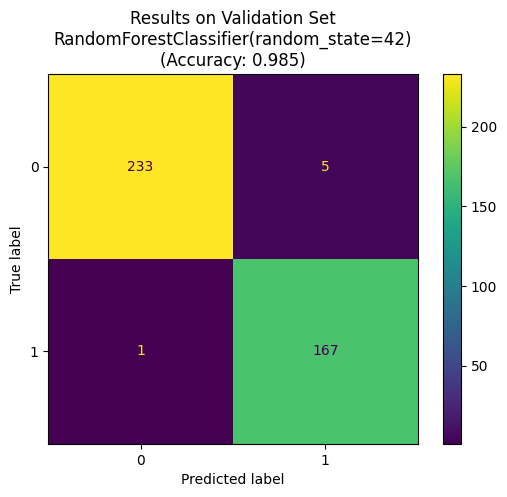

In [99]:
# select the winning model
best_model = models["Random Forest"]

def validate_trained_model(model):
    # evaluate on validation set
    y_pred = model.predict(X_val)
    # compute accuracy score and confusion matrix
    accuracy = model.score(X_val, y_val)
    conf_mat = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots()
    conf_mat_disp = ConfusionMatrixDisplay(conf_mat)
    conf_mat_disp.plot(ax=ax)
    # plt.show()
    ax.set_title(f"Results on Validation Set\n{model}\n(Accuracy: {accuracy:.3f})")

validate_trained_model(best_model)


In [100]:
def get_groups_with_errors(model):
    # evaluate on all good data
    y_pred = model.predict(X_good)
    # add results as column in copy of good data
    good_data_plus = good_data.copy()
    good_data_plus['pred'] = y_pred.astype('int8')
    # get exercise groups in good data
    groups = good_data['grp'].unique()
    groups_with_errors = []
    for grp in groups:
        view_cols = ['set_count', 'date', 'type', 'weight', 'reps', 'warm_up', 'pred']
        df = good_data_plus[good_data_plus['grp'] == grp][view_cols]
        all_pred_correct = (df['warm_up'] == df['pred']).all()
        if not all_pred_correct:
            groups_with_errors.append(df)
    return groups_with_errors

groups_with_errors = get_groups_with_errors(best_model)
print("Number of groups with errors:".upper(), len(groups_with_errors))
print("\nGroups with errors:\n".upper())
for group in groups_with_errors:
    print(group)

NUMBER OF GROUPS WITH ERRORS: 9

GROUPS WITH ERRORS:

      set_count        date      type  weight  reps  warm_up  pred
1169          1  2020-06-08  Deadlift    60.0     5        1     1
1170          2  2020-06-08  Deadlift    70.0     5        1     0
1171          3  2020-06-08  Deadlift    80.0     5        0     0
1172          4  2020-06-08  Deadlift    90.0     5        0     0
1173          5  2020-06-08  Deadlift    90.0     5        0     0
      set_count        date            type  weight  reps  warm_up  pred
1374          1  2020-08-04  Overhead Press    20.0     5        1     1
1375          2  2020-08-04  Overhead Press    35.0     2        1     1
1376          3  2020-08-04  Overhead Press    40.0     1        0     1
1383          4  2020-08-04  Overhead Press    38.0     1        1     1
1384          5  2020-08-04  Overhead Press    42.0     1        0     1
1385          6  2020-08-04  Overhead Press    45.0     1        0     0
1386          7  2020-08-04  Over

Altogether, this is rather satisfactory. The errors are limited to nine exercise groups, six of which were "max out sessions" where I went for new personal bests for single repetitions. These groups are certainly outliers. 

### A Deep Learning Approach



Just out of curiosity, I will try training a neural network. The first task is to convert the data to PyTorch's very own `torch.tensor` data type.

In [101]:
# Convert to PyTorch tensors
def convert_pandas_to_torch(panda):
    by_way_of_numpy = panda.values.astype(np.float64)
    tensor = torch.tensor(by_way_of_numpy, dtype=torch.double)
    return tensor
X_train = convert_pandas_to_torch(X_train)
y_train = convert_pandas_to_torch(y_train).unsqueeze(1)
X_test = convert_pandas_to_torch(X_test)
y_test = convert_pandas_to_torch(y_test).unsqueeze(1)
X_val = convert_pandas_to_torch(X_val)
y_val = convert_pandas_to_torch(y_val).unsqueeze(1)

As for the neural network model, I will go for three linear layers with sigmoid activation functions. Since I don't have a ton of training data, I will keep the number of parameters manageable. 

In [102]:
# define a simple neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.Sigmoid(),
            nn.Linear(16, 8),
            nn.Sigmoid(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# define model, loss function, and optimizer
model_nn = SimpleNN(input_dim=X_train.shape[1]).double()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.01)

print("Number of parameters:", sum(p.numel() for p in model_nn.parameters()))
print("Neural Network Architecture:")
print(model_nn)


Number of parameters: 337
Neural Network Architecture:
SimpleNN(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


---=== FIRST PASS ===---
Epoch 0, Loss: 0.7396
Epoch 1000, Loss: 0.0169
Epoch 2000, Loss: 0.0327
Epoch 3000, Loss: 0.0265
Epoch 4000, Loss: 0.0215
Epoch 5000, Loss: 0.0290
Epoch 6000, Loss: 0.0259
Epoch 7000, Loss: 0.0237
Epoch 8000, Loss: 0.0196
Epoch 9000, Loss: 0.0176
Epoch 10000, Loss: 0.0158
Test Accuracy: 98.63%


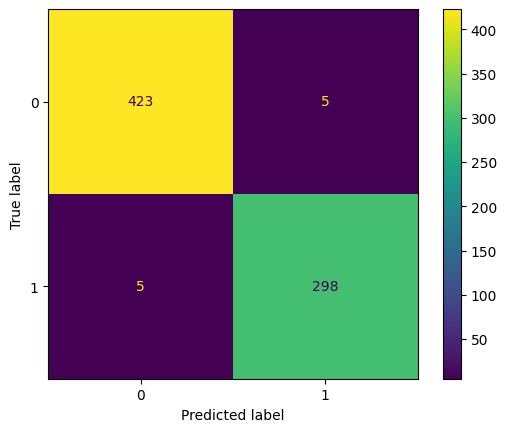

---=== SECOND PASS ===---
Epoch 0, Loss: 0.0159
Epoch 1000, Loss: 0.0146
Epoch 2000, Loss: 0.0121
Epoch 3000, Loss: 0.2707
Epoch 4000, Loss: 0.0256
Epoch 5000, Loss: 0.0239
Epoch 6000, Loss: 0.0213
Epoch 7000, Loss: 0.6787
Epoch 8000, Loss: 0.6787
Epoch 9000, Loss: 0.6787
Epoch 10000, Loss: 0.6787
Test Accuracy: 58.55%


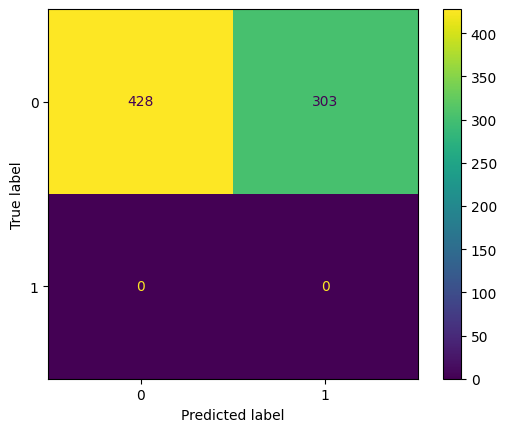

In [103]:
def train_and_evaluate_nn(model_nn, epochs=10001):
    # train the neural network
    for epoch in range(epochs):
        model_nn.train()
        optimizer.zero_grad()
        outputs = model_nn(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    # evaluate classification results
    model_nn.eval()
    with torch.no_grad():
        preds = model_nn(X_test)
        preds_binary = (preds > 0.5).int()
        accuracy = (preds_binary.squeeze() == y_test.squeeze().int()).float().mean().item()
        print(f"Test Accuracy: {accuracy:.2%}")
        conf_mat = confusion_matrix(preds_binary, y_test)
        conf_mat_disp = ConfusionMatrixDisplay(conf_mat)
        conf_mat_disp.plot()
        plt.show()

# run training and evaluation twice to compare results
print("---=== FIRST PASS ===---")
train_and_evaluate_nn(model_nn)
print("---=== SECOND PASS ===---")
train_and_evaluate_nn(model_nn)

The first result is actually quite promising. However, the second attempt clearly shows that things can go wrong when training neural networks. I could go on and investigate what went wrong (most likely a zero-gradient issue), but given the good performance of the much simpler classical models, I will not pursue the matter any further. 

### The Final Implementation

Based on the experiments in the previous sections, I will use a random forest classifier to correct the wrond exercise IDs in the "problem data".

In [104]:
def predict_warm_ups(prepared_data):
    # split data
    good_data, _ = good_problem_split(prepared_data)
    # extract features X and target y
    IGNORE_COLS = ['date', 'label', 'type', 'exc_id', 'set_id', 'grp', 'warm_up']
    X_good = good_data.drop(IGNORE_COLS, axis=1)
    y_good = good_data['warm_up']
    # train random forest model
    random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
    warm_up_predictor = random_forest.fit(X_good, y_good)
    # make predictions and add in column 'pred'
    X_all = prepared_data.drop(IGNORE_COLS, axis=1)
    y_all_pred = warm_up_predictor.predict(X_all)
    # add prediction colun to copy of data and return
    data_pred = prepared_data.copy()
    data_pred['pred'] = pd.Series(y_all_pred).astype('Int8')
    return data_pred

## Step 4: Fixing the Database

It remains to update the database file using the predicted exercise IDs for the "problem sets" recorded before the `SPLIT_DATE`. This process is straight forward. 

First, two helper functions are needed:
one to obtain IDs of the "bad sets", that is, those that need to be changed,
and another one to determine the new exercise ID from the old one. 

In [105]:
def get_bad_set_ids(data_pred):
    _, problems = good_problem_split(data_pred)
    bad_set_ids = problems.query('pred == 1')['set_id']
    return bad_set_ids

In [106]:
new_exc_id_query = """
SELECT 
	W._id as "new_id"
FROM
	exercise E, 
	exercise W, 
	training_log T
WHERE 
	W.name = E.name || ' (Warm Up)' AND
	E._id = T.exercise_id AND 
	T._id = {:s}
"""

def get_warm_up_id(set_id:int)->int:
    id_df = run_query(new_exc_id_query.format(f"{set_id}"))
    warm_up_exc_id = id_df['new_id'][0]
    return warm_up_exc_id


With the bad set IDs and their corresponding new exercise IDs available, the database can be updated. To avoid data loss, I will implement an option that by default creates a new file with the updated IDs, leaving the original file untouched. 

In [107]:
def update_db_file(db_file, bad_ids, inplace=False):
    # create copy for update unless 'inplace' options
    if not inplace:
        original_db_file = db_file
        timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
        db_file = original_db_file.replace(
            '.fitnotes', 
            f'__exc_ids_fixed_{timestamp}.fitnotes'
        )
        shutil.copyfile(original_db_file, db_file)
    # update the db entries
    update_query_template = """
    UPDATE training_log
    SET exercise_id = {exc_id:s}
    WHERE _id = {set_id};
    """
    with sqlite3.connect(db_file) as conn:
        cur = conn.cursor()
        for set_id in bad_ids:
            new_exc_id = get_warm_up_id(set_id)
            update_query = update_query_template.format(
                set_id=str(set_id),
                exc_id=str(new_exc_id),
            )
            cur.execute(update_query)
        conn.commit()

Now everything needed for the main function `fix_db_file` is ready for assembly.

In [113]:
def fix_db_file(db_file=FITNOTES_BACKUP, inplace=False):
    # data gathering
    data = load_data(db_file)
    # prepare data
    prepared_data = prepare_data(data)
    # make prediction
    predicted_data = predict_warm_ups(prepared_data)
    bad_set_ids = get_bad_set_ids(predicted_data)
    # update database file
    update_db_file(db_file, bad_set_ids, inplace=inplace)
    return predicted_data

final_data = fix_db_file()


Finally, here's how the model performed on the last 25 "problem sets". All in all, rather satisfactory.

In [116]:
_, problem_data = good_problem_split(final_data)
view_cols = ['date','type','set_count','weight','reps','pred']
problem_data[view_cols].tail(25)

,date,type,set_count,weight,reps,pred
1009,2020-01-31,Deadlift,7,105.0,5,0
1010,2020-01-31,Deadlift,8,90.0,10,0
1011,2020-01-31,Bench Press,4,52.0,3,0
1012,2020-02-02,Bench Press,1,20.0,5,1
1013,2020-02-02,Bench Press,2,40.0,3,1
1014,2020-02-02,Bench Press,3,50.0,2,1
1015,2020-02-02,Bench Press,4,50.0,6,0
1016,2020-02-02,Bench Press,5,50.0,3,0
1017,2020-02-02,Bench Press,6,47.0,5,0
1018,2020-02-02,Bench Press,7,47.0,5,0
